In [194]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from qiskit.extensions import XGate
import math

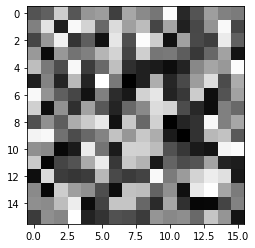

In [335]:
image = np.random.uniform(low=0, high=255, size=(16,16)).astype(int)
plt.imshow(image, cmap = 'gray')

In [339]:
x = int(np.ceil(math.log(image.shape[0], 2)))
if int(x) == 0: x = 1
y = int(np.ceil(math.log(image.shape[1], 2)))
if int(y) == 0: y = 1
q = 8

color = QuantumRegister(q, 'color')
y_ax = QuantumRegister(y, 'y axis')
x_ax = QuantumRegister(x, 'x axis')
classic = ClassicalRegister(x+y+q, 'classic')
qc = QuantumCircuit(color, y_ax, x_ax, classic)

qc.i(color)
qc.h(x_ax)
qc.h(y_ax)
qc.barrier()
controls_ = []
for i, _ in enumerate(x_ax):
    controls_.extend([x_ax[i]])
for i, _ in enumerate(y_ax):
    controls_.extend([y_ax[i]])  
for xi in range(image.shape[0]):
    xi_bin = "{0:b}".format(xi).zfill(x_ax.size)
    for i, bit in enumerate(xi_bin):
        if not int(bit):
            qc.x(x_ax[i])  
    qc.barrier()
    for yi in range(image.shape[1]):
        yi_bin = "{0:b}".format(yi).zfill(y_ax.size)
        for i, bit in enumerate(yi_bin):
            if not int(bit):
                qc.x(y_ax[i]) 
        qc.barrier()
        intensity_bin = "{0:b}".format(image[xi, yi]).zfill(len(color))
        xg = XGate(None).control(len(controls_))
        target = []
        for i, bit in enumerate(intensity_bin):
            if int(bit):
                qc.mcx(controls_, color[i])
        qc.barrier()
        for i, bit in enumerate(yi_bin):
            if not int(bit):
                qc.x(y_ax[i])
        qc.barrier()
    for i, bit in enumerate(xi_bin):
        if not int(bit):
            qc.x(x_ax[i])
    qc.barrier()

qc.measure(x_ax, range(x_ax.size))
qc.measure(y_ax, range(x_ax.size, x_ax.size+y_ax.size))
qc.measure(color, range(x_ax.size+y_ax.size,x_ax.size+y_ax.size+color.size))

Metrics

| Image size  | Depth measure | # of utilized qubits
| ------------- | ------------- | -------------------|
| 2  | 26  | 3 |
| 4  | 107  | 5 |
| 8  | 431  | 7 |
| 16  | 1727  | 9 |
| 32  | 6911  | 11|
| 64  | 27647  | 13 |
| 128  | 110591  | 15 |
| 256  | 442367  | 17 |

In [338]:
print("depth is {}, # of qubits is {}".format(qc.depth(), qc.num_qubits))

depth is 1490, # of qubits is 16


In [340]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc, aer_sim)
qobj = assemble(t_qc_image, shots=80000)
job_neqr = aer_sim.run(qobj)
result_neqr = job_neqr.result()
counts_neqr = result_neqr.get_counts()
counts_neqr = (["".join(list(reversed(c))) for c in counts_neqr])

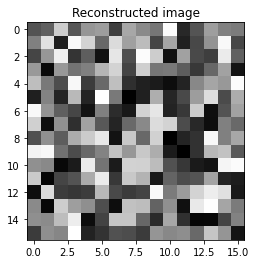

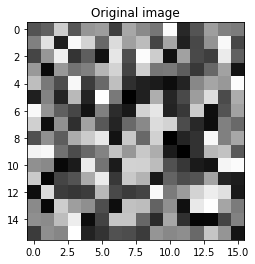

[[ 84.  96. 204.  86. 150. 157.  64. 167. 138. 118. 250.  42.  85. 158.
  129. 123.]
 [128. 225.  32. 248. 210. 104. 218. 160. 187.  70. 166.  34.  73. 148.
  248.  72.]
 [ 70. 151. 239.  54.  94.  18. 229.  80. 251. 204.  18. 161.  75.  63.
  234.  96.]
 [153.  11. 152. 115. 128. 180. 211.  69. 206. 118. 122.  93.  58. 103.
  162.  20.]
 [189. 121.  78. 247.  61. 106. 190.  48.  33.  28.  14.  36. 136. 165.
  152. 251.]
 [ 32. 132.  37. 184.  37. 254. 122.   2.  33. 173.  39.  75. 157. 220.
   76. 171.]
 [248. 147.  95.  71.  19. 128.  45.  25. 209. 229.  36.  57. 203.  15.
   84. 162.]
 [207.  15. 145.  48. 162.  88.  37. 105. 137. 219. 211.  77.  42.  14.
  128. 105.]
 [ 81. 144.  93. 171. 202. 231.  19. 199. 104. 208.   2.  38.  51. 247.
  128. 167.]
 [242. 247. 113.  77. 104. 132. 193. 151. 199. 172.  28.   1.  51. 183.
  193.  90.]
 [144. 137.   9.  28. 234. 116.  28. 209. 208. 187.  82.  56.  27.  20.
  244. 250.]
 [201.   6.  70.  84. 170. 234.  57. 199. 178.  26. 100.  77.  85

In [341]:
out_pixels = []
for item in counts_neqr:
    out_pixels.append((int(item[0:x], 2), int(item[x:x+y],2), int(item[-q:],2)))
out_image = np.zeros(image.shape)
for pixel in out_pixels:
    if pixel[0]<out_image.shape[0]:
        if pixel[1]<out_image.shape[1]:
            out_image[pixel[0], pixel[1]] = pixel[2]
plt.imshow(out_image, cmap = 'gray')
plt.title('Reconstructed image')
plt.show()
plt.imshow(image, cmap = 'gray')
plt.title('Original image')
plt.show()
print(out_image, '\n', image)

# DONE

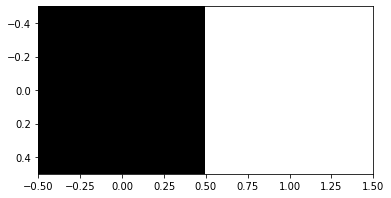

In [95]:
image = np.array([0,1]).reshape(1,2)
color_bit_range = 1
plt.imshow(image, cmap = 'gray')
plt.show()

In [ ]:
x = 1
y = 1
q = 1

color = QuantumRegister(q, 'color')
y_ax = QuantumRegister(y, 'y axis')
x_ax = QuantumRegister(x, 'x axis')
classic = ClassicalRegister(x+y+q, 'classic')
qc = QuantumCircuit(color, y_ax, x_ax, classic)

qc.i(color)
qc.h(x_ax)
qc.h(y_ax)
qc.barrier()

#first pixel
qc.i(range(0,qc.num_qubits))
qc.barrier()

#second pixel
qc.x(y_ax)
qc.ccx(x_ax[0], y_ax[0], color[0])
qc.x(y_ax)
qc.barrier()

#measure
qc.measure(list(reversed(range(qc.num_qubits))), range(classic.size))

qc.draw()

┌───┐ ░ ┌───┐ ░      ┌───┐      ░       ┌─┐
  color_0: ┤ I ├─░─┤ I ├─░──────┤ X ├──────░───────┤M├
           ├───┤ ░ ├───┤ ░ ┌───┐└─┬─┘┌───┐ ░    ┌─┐└╥┘
 y axis_0: ┤ H ├─░─┤ I ├─░─┤ X ├──■──┤ X ├─░────┤M├─╫─
           ├───┤ ░ ├───┤ ░ └───┘  │  └───┘ ░ ┌─┐└╥┘ ║ 
 x axis_0: ┤ H ├─░─┤ I ├─░────────■────────░─┤M├─╫──╫─
           └───┘ ░ └───┘ ░                 ░ └╥┘ ║  ║ 
classic: 3/═══════════════════════════════════╩══╩══╩═
                                              0  1  2

In [ ]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc, aer_sim)
qobj = assemble(t_qc_image, shots=1000000)
job_neqr = aer_sim.run(qobj)
result_neqr = job_neqr.result()
counts_neqr = result_neqr.get_counts()
plot_histogram(counts_neqr)
plt.show()

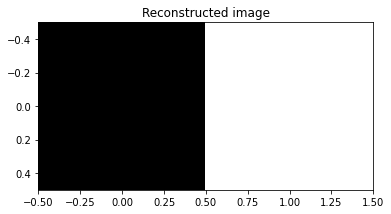

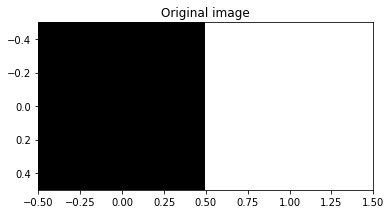

In [ ]:
out_pixels = []
for item in counts_neqr:
    out_pixels.append((int(item[0:color.size], 2), int(item[color.size:],2)))
out_image = np.zeros((len(image.flatten(),)))
for pixel in out_pixels:
    if pixel[1]<out_image.shape[0]:
        out_image[pixel[1]] = pixel[0]
out_image = np.reshape(out_image, (image.shape))
plt.imshow(out_image, cmap = 'gray')
plt.title('Reconstructed image')
plt.show()
plt.imshow(image, cmap = 'gray')
plt.title('Original image')
plt.show()